In [2]:
import statsmodels.api as sm
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
sns.set_style('whitegrid')

# BNN

In [3]:
def type_wise_results(dict_numtest_samples,y_test,arr_pred_test,aleatoric_uncertainty,epistemic_uncertainty):
    dict_result = {}
    temp_prev = 0
    list_accuracy = []
    for i in range(31):
        temp = dict_numtest_samples[i]
        sliced_y_pred = arr_pred_test[temp_prev:temp_prev+temp]
        sliced_y_test = y_test[temp_prev:temp_prev+temp]
        al_uncertainty_test = aleatoric_uncertainty[temp_prev:temp_prev+temp]
        ep_uncertainty_test = epistemic_uncertainty[temp_prev:temp_prev+temp]
        dict_result[i] = [sliced_y_test,sliced_y_pred,al_uncertainty_test,ep_uncertainty_test]
        temp_prev = temp_prev+temp
    return dict_result



def placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,shape=[n_y,None],name='Y')
    return (X,Y)


def forward_propagation(X,layers_dims,param_normal, keep_prob=1.0):
    
    def sample_epsilons(param_normal):
        epsilons_W = []
        epsilons_b = []
        for i in range(len(layers_dims)-1):
            epsilons_W.append(tf.random_normal(shape=tf.shape(param_normal["mu_W"+str(i+1)]), mean=0., stddev=1.0))
            epsilons_b.append(tf.random_normal(shape=tf.shape(param_normal["mu_b"+str(i+1)]), mean=0., stddev=1.0))
        return epsilons_W,epsilons_b

    def transform_rhos(layers_dims,param_normal):
        for i in range(len(layers_dims)-1):
            param_normal["rho_W"+str(i+1)] = softplus(param_normal["rho_W"+str(i+1)])
            param_normal["rho_b"+str(i+1)] = softplus(param_normal["rho_b"+str(i+1)])
        return param_normal

    def make_gaussian_samples(param_normal,layers_dims,epsilons_W,epsilons_b):
        samples_W = []
        samples_b = []
        for i in range(len(layers_dims)-1):
            samples_W.append(tf.add(param_normal["mu_W"+str(i+1)],tf.multiply( param_normal["rho_W"+str(i+1)] , epsilons_W[i])))
            samples_b.append(tf.add(param_normal["mu_b"+str(i+1)] ,tf.multiply( param_normal["rho_b"+str(i+1)] , epsilons_b[i])))
        return samples_W, samples_b

    epsilons_W,epsilons_b = sample_epsilons(param_normal)
    param_normal = transform_rhos(layers_dims,param_normal)
    samples_W, samples_b =  make_gaussian_samples(param_normal,layers_dims,epsilons_W,epsilons_b)
    
    store = {}
    store['A0'] = X
    for l in range(len(layers_dims)-1):
        store["Z"+str(l+1)] = tf.add(tf.matmul(samples_W[l],store["A"+str(l)]),samples_b[l])
        if (l == len(layers_dims) - 2):
            return store["Z"+str(l+1)],samples_W,samples_b
        store["A"+str(l+1)] = tf.nn.sigmoid(store["Z"+str(l+1)])
        store["A"+str(l+1)] = tf.nn.dropout(store["A"+str(l+1)], keep_prob)


def initialization(layers_dims):
    param_normal = {}
    for l in range(len(layers_dims)-1):
        param_normal["mu_W"+str(l+1)] = tf.get_variable('mu_W'+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer =  tf.random_normal_initializer(mean = 0.0,stddev = 0.1))
        param_normal["rho_W"+str(l+1)] = -15.5 + tf.get_variable("rho_W"+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer = tf.zeros_initializer())
        param_normal["mu_b"+str(l+1)] = tf.get_variable('mu_b'+str(l+1),[layers_dims[l+1],1],initializer =  tf.random_normal_initializer(mean = 0.0,stddev = 0.1))
        param_normal["rho_b"+str(l+1)] =  -16.5 + tf.get_variable("rho_b"+str(l+1),[layers_dims[l+1],1],initializer = tf.zeros_initializer())
    return param_normal 


def softplus(x):
    return tf.log(1.0 + tf.exp(x))

def log_gaussian(x, mu,sigma):
    return -0.5 * tf.log(2.0 * tf.constant(math.pi)) - tf.log(sigma) - tf.truediv(tf.multiply((x-mu),(x-mu)), (2.0 * tf.multiply(sigma,sigma)))

def prior(x):
    mean_prior = tf.constant(0.0)
    sigma_prior = tf.constant(1.0)
    return tf.reduce_sum(log_gaussian(x,mean_prior,sigma_prior))

def gaussian(x,mu,sigma):
    scaling = tf.truediv(1.0,tf.sqrt(2.0 * tf.constant(math.pi) * tf.multiply(sigma,sigma)))
    bell = tf.exp(-1.0 * tf.truediv(tf.multiply((x-mu),(x-mu)), (2.0 * tf.multiply(sigma,sigma))))
    return tf.multiply(scaling,bell)

def scale_mixture_prior(x):
    sigma_p1 = tf.constant(0.2)
    sigma_p2 = tf.constant(0.8)
    pi = 0.15
    first_gaussian = tf.constant(pi) * gaussian(x,0.0,sigma_p1)
    second_gaussian = (1.0-tf.constant(pi)) * gaussian(x,0.0,sigma_p2)
    return tf.reduce_sum(tf.log(first_gaussian+second_gaussian))

def log_softmax_likelihood(ZL, y):
    return  -1 * tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y),logits=tf.transpose(ZL),))


def compute_cost(layers_dims,samples_W,samples_b,param_normal,ZL,label_one_hot):
    log_likelihood_sum = log_softmax_likelihood(ZL, label_one_hot)
    log_prior_list = []
    log_var_posterior_list = []
    for i in range(len(layers_dims)-1):
        log_prior_list.append(prior(samples_W[i]))
        log_prior_list.append(prior(samples_b[i]))
        log_var_posterior_list.append(tf.reduce_sum(log_gaussian(samples_W[i],param_normal["mu_W"+str(i+1)],param_normal["rho_W"+str(i+1)])))
        log_var_posterior_list.append( tf.reduce_sum(log_gaussian(samples_b[i],param_normal["mu_b"+str(i+1)],param_normal["rho_b"+str(i+1)])))
    log_prior_sum = sum(log_prior_list)
    log_var_posterior_sum = sum(log_var_posterior_list)
    return 1/(X_train.shape[1]) * (log_var_posterior_sum - log_prior_sum -  log_likelihood_sum)#log_likelihood_sum #(log_var_posterior_sum - log_prior_sum -  log_likelihood_sum)   #((log_var_posterior_sum - log_prior_sum) 


def model(X_train,Y_train,X_test,Y_test,learning_rate,num_epochs,print_cost,layers_dims):
    tf.reset_default_graph()
    tf.set_random_seed(1234)
    n_x = X_train.shape[0]
    m = X_train.shape[1]
    n_y = Y_train.shape[0]
    costs =[]
    (X,Y) = placeholders(n_x,n_y)
    param_normal = initialization(layers_dims)
    ZL,samples_W,samples_b = forward_propagation(X,layers_dims,param_normal)
    loss = compute_cost(layers_dims,samples_W,samples_b,param_normal,ZL,Y_train)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss) 
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            _,epoch_cost = sess.run([optimizer,loss],feed_dict={X : X_train, Y : Y_train})
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        logit_final_temp = tf.nn.softmax(ZL,axis=0)
        list_logit_train = []
        list_logit_test = []
        list_Z = []
        for pred in range(0,500):
            logit_final_test = logit_final_temp.eval(feed_dict={X: X_test})
            logit_final_train = logit_final_temp.eval(feed_dict = {X: X_train})
            Z = ZL.eval(feed_dict={X: X_test})
            list_logit_train.append(logit_final_train)
            list_logit_test.append(logit_final_test)
            list_Z.append(Z)
            if pred == 0:
                arr_pred_train = np.argmax(logit_final_train, axis= 0)
                arr_pred_test = np.argmax(logit_final_test,axis=0)
                train_accuracy =  np.sum(arr_pred_train == Ytrain) / len(arr_pred_train)
                test_accuracy = np.sum(arr_pred_test == Ytest) / len(arr_pred_test)
                grad = tf.gradients(logit_final_temp,X)
                grad_val = sess.run(grad, feed_dict = {X:X_train})
    print("Train Accuracy: "+str(train_accuracy*100)[0:5]+"%")
    print("Test Accuracy: "+str(test_accuracy*100)[0:5]+"%")
    return [train_accuracy,test_accuracy,list_logit_test,list_logit_train,arr_pred_test,arr_pred_train,grad_val]


# Uncertainty

In [4]:
df_label = pd.read_csv('D:/New Folder/labels.csv',header=1)
label = list(df_label['Abbreviation'])


def detailed_plot_new(dict_result_train,uncertainty_type,y_test,arr_pred_test,al_test,image_name,cancer_types,scal_fac=1e9):
 
    dict_mean_train = {}
    dict_mean_test_corr = {}
    dict_mean_test_incorr = {}
    for i in range(len(cancer_types)):
    
       
        train = dict_result_train[i][0]
        pred_train = dict_result_train[i][1]
        al_train_temp = dict_result_train[i][2]
        ep_train_temp = dict_result_train[i][3]
        
        
        
      
        
        list_index = list(np.where(arr_pred_test == i)[0])
        list_index2 = list(np.where(y_test==i)[0])
    
        correct_index = []
        incorrect_index = []
        for j in range(len(list_index)):
            if (list_index[j] in list_index2) == True:
                correct_index.append(j)
            else:
                incorrect_index.append(j)
        
        
        corr_al = al_test[list(np.array(list_index)[correct_index])]
        incorr_al = al_test[list(np.array(list_index)[incorrect_index])]
        
       
        list_combined = list(corr_al)+list(incorr_al)
        
        index_temp_incorr = []
        index_temp = []
        for j in range(len(list_combined)):
            index_temp.append(j)
            if (j >= len(corr_al)):
                index_temp_incorr.append(j)
        
        
        l_final, l_index_final = shuffle(list_combined, index_temp, random_state=0)
        
        
        
      
        
        incorrect = []
        for j in range(len(l_index_final)):
            if (l_index_final[j] in index_temp_incorr) ==True:
                incorrect.append(j)
        
        
        correct_train = []
        incorrect_train = []
        for k in range(len(list(pred_train))):
            if (pred_train[k] != train[k]):
                incorrect_train.append(k)
            else:
                correct_train.append(k)

        if uncertainty_type == 'Aleatoric':

            corr = np.mean(corr_al)
            incorr = np.mean(incorr_al)
            corr_train = np.mean(al_train_temp[correct_train])
            dict_mean_train[i] = corr_train
            dict_mean_test_corr[i] = corr
            dict_mean_test_incorr[i] = incorr
            
        if uncertainty_type == 'Epistemic':
            
            corr = np.mean(corr_al)*scal_fac
            incorr = np.mean(incorr_al)*scal_fac
            corr_train = np.mean(ep_train_temp[correct_train])*scal_fac
            dict_mean_train[i] = corr_train
            dict_mean_test_corr[i] = corr
            dict_mean_test_incorr[i] = incorr
            
       
    return dict_mean_train,dict_mean_test_corr,dict_mean_test_incorr


def uncertainty_calculation(logits,y_test,arr_pred_test,type_uncer,t,t_l,image_name,scal_fac=1e-9):
    
        aleo_list = []
        for j in range(len(logits)):
            prob_list = []
            for i in range(logits[j].shape[1]):
                arg = np.argmax(logits[j][:,i])
                prob = logits[j][:,i][arg]
                prob_list.append(prob)
            aleo = list(np.array(prob_list) - np.square(np.array(prob_list)))
            aleo_list.append(aleo)
            
        epi_list = []
        for j in range(len(logits)):
            prob_list = []
            for i in range(logits[j].shape[1]):
                arg = np.argmax(logits[j][:,i])
                prob = logits[j][:,i][arg]
                prob_list.append(prob)
            epi_list.append(np.array(prob_list))
        epistemic_uncertainty = np.mean(np.square((np.array(epi_list)-np.mean(np.array(epi_list),axis=0))),axis=0)
        aleoteric_uncertainty = np.mean(np.array(aleo_list),axis=0)
        
        incorrect = []
        for i in range(len(list(arr_pred_test))):
            if (arr_pred_test[i] != np.array(y_test)[i]):
                incorrect.append(i)
                
        list_aleoteric_correct = []
        list_aleoteric_incorrect = []
        for i in range(len(aleoteric_uncertainty)):
            if (i in incorrect) == True:
                list_aleoteric_incorrect.append(aleoteric_uncertainty[i])
            if (i in incorrect) == False:
                list_aleoteric_correct.append(aleoteric_uncertainty[i])
                
        list_epistemic_correct = []
        list_epistemic_incorrect = []
        for i in range(len(epistemic_uncertainty)):
            if (i in incorrect) == True:
                list_epistemic_incorrect.append(epistemic_uncertainty[i])
            if (i in incorrect) == False:
                list_epistemic_correct.append(epistemic_uncertainty[i])
                
        corr = np.mean(np.array(list_aleoteric_correct))
        incorr = np.mean(np.array(list_aleoteric_incorrect))
        corr_epistemic = np.mean(np.array(list_epistemic_correct))
        incorr_epistemic = np.mean(np.array(list_epistemic_incorrect))
        
        if type_uncer == 'Aleatoric':
            fig = plt.figure()
            ax1 = fig.add_axes([0, 0, 1, 1])
            ax2 = fig.add_axes()
            ax2 = ax1.twinx()
            ax1.tick_params(axis='y', labelcolor='b')
            ax2.tick_params(axis='y', labelcolor='r')

            
            sns.kdeplot(list_aleoteric_correct,color='b',ax=ax1)
            sns.kdeplot(list_aleoteric_incorrect,color='r',ax=ax2).set(xlim=(0, 0.35))
   
            if t == 'Train':
                plt.axvline(x=corr,c= 'b',linestyle='--',label = 'Mean uncertainty (correct)')
                plt.axvline(x=incorr, c = 'r',linestyle='--',label = 'Mean uncertainty (incorrect)')
                plt.close()
                
   
            if t== 'Test':
                plt.axvline(x=corr, c = 'b',linestyle='--',label= 'Mean test uncertainty (correct)')
                plt.axvline(x=incorr,c= 'r',linestyle='--',label = 'Mean test uncertaity (incorrect)')
                plt.axvline(x=t_l, c = 'g',linestyle='--',label = 'Mean train uncertainty (correct)')
                plt.legend(bbox_to_anchor=(1.6,1))
                ax1.set_ylabel('Density (Correct Predictions)', color='b',fontsize=15)
                ax2.set_ylabel('Density (Incorrect Predictions)', color='r',fontsize=15)
                ax1.set_xlabel('Aleatoric Uncertainty',fontsize = 15)
                            
           
            plt.close()
            
            return [aleoteric_uncertainty,corr,incorr]

        if type_uncer == 'Epistemic':
            fig = plt.figure()
            ax1 = fig.add_axes([0, 0, 1, 1])
            ax2 = fig.add_axes()
            ax2 = ax1.twinx()
            ax1.tick_params(axis='y', labelcolor='b')
            ax2.tick_params(axis='y', labelcolor='r')
           
            
            sns.kdeplot(np.array(list_epistemic_correct)/scal_fac,color='b',ax=ax1)
            sns.kdeplot(np.array(list_epistemic_incorrect)/scal_fac,color='r',ax=ax2).set(xlim=(0, 2))
   
            if t == 'Train':
                plt.axvline(x=corr_epistemic/scal_fac, c = 'b',linestyle='--',label = 'Mean uncertainty (correct)')
                plt.axvline(x=incorr_epistemic/scal_fac,c= 'r',linestyle='--',label = 'Mean uncertainty (incorrect)')
                plt.close()
                
   
            if t== 'Test':
                plt.axvline(x=corr_epistemic/scal_fac, c = 'b',linestyle='--',label = 'Mean test uncertainty (correct)')
                plt.axvline(x=incorr_epistemic/scal_fac,c= 'r',linestyle='--',label = 'Mean test uncertainty (incorrect)')
                plt.axvline(x=t_l*scal_fac, c = 'g',linestyle='--',label='Mean train uncertainty (correct)')
                plt.legend(bbox_to_anchor=(1.6,1))
                ax1.set_ylabel('Density (Correct Predictions)', color='b',fontsize=15)
                ax2.set_ylabel('Density (Incorrect Predictions)', color='r',fontsize=15)
                ax1.set_xlabel('Epistemic Uncertainty (x '+str(r'$10^{'+str(scal_fac).split('e')[-1]+'}$')+')',fontsize = 15)
            
            
            plt.close()
            
            return [epistemic_uncertainty,corr_epistemic,incorr_epistemic]


def com_ep_un(logits,arg_passed='argmax'):        
    epi_list = []
    for j in range(len(logits)):
        prob_list = []
        for i in range(logits[j].shape[1]):
            if arg_passed=='argmax':
                arg = np.argmax(logits[j][:,i])
            else:
                arg = arg_passed
            prob = logits[j][:,i][arg]
            prob_list.append(prob)
        epi_list.append(np.array(prob_list))
        
    epistemic_uncertainty = np.mean(np.square((np.array(epi_list)-np.mean(np.array(epi_list),axis=0))),axis=0)
    
    return epistemic_uncertainty



def uncertainty_correction(test_logits):
    
    adjusted_logits_complete = []
    mean_test_logits = sum(test_logits)/len(test_logits)
    func_mean_test_logits = np.log(np.array(mean_test_logits)/(1-np.array(mean_test_logits)))
    
    
    for index in range(test_logits[0].shape[0]):
    
       
        epistemic_test = np.sqrt(com_ep_un(test_logits,index))
        epistemic_test_norm = epistemic_test/np.max(epistemic_test)

        X = epistemic_test_norm
        Y = list(func_mean_test_logits[index,:])
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        adj_logits = func_mean_test_logits[index,:]-model.params[1]*epistemic_test_norm
        func_inv_adj_logits = np.exp(adj_logits)/(1+np.exp(adj_logits))
        adjusted_logits_complete.append(func_inv_adj_logits)

    return adjusted_logits_complete



def uncertainty_analysis(logits_train,y_train,arr_pred_train,logits,y_test,arr_pred_test,scal_fac,analysis_type):
    [al_train,mu_train_ac,mu_train_nac] = uncertainty_calculation(logits_train,y_train,arr_pred_train,'Aleatoric','Train',_,analysis_type)
    [ep_train,mu_train_ec,mu_train_nec] = uncertainty_calculation(logits_train,y_train,arr_pred_train,'Epistemic','Train',_,analysis_type,scal_fac)
    [al_test,mu_test_ac,mu_test_nac] = uncertainty_calculation(logits,y_test,arr_pred_test,'Aleatoric','Test',mu_train_ac,analysis_type)
    [ep_test,mu_test_ec,mu_test_nec] = uncertainty_calculation(logits,y_test,arr_pred_test,'Epistemic','Test',mu_train_ec,analysis_type,scal_fac)
    dict_numtrain_samples = Counter(np.array(y_train))
    dict_numtest_samples = Counter(np.array(y_test))
    dict_result_train = type_wise_results(dict_numtrain_samples,np.array(y_train),arr_pred_train,al_train,ep_train)
    dict_result_test = type_wise_results(dict_numtest_samples,np.array(y_test),arr_pred_test,al_test,ep_test)
    dict_result_train = type_wise_results(dict_numtrain_samples,np.array(y_train),arr_pred_train,al_train,ep_train)
    dict_result_test = type_wise_results(dict_numtest_samples,np.array(y_test),arr_pred_test,al_test,ep_test)
    dict_mean_ep,dict_mean_test_corr,dict_mean_test_incorr = detailed_plot_new(dict_result_train,'Epistemic',np.array(y_test),arr_pred_test,ep_test,'epistemic_uncertainty_cancer_wise',cancer_types,1/scal_fac)
    list_final_pred = []
    list_final_test = []
    uncertain = []
    certain = []
    for i in range(len(arr_pred_test)):
        if (ep_test[i]/scal_fac <= dict_mean_ep[arr_pred_test[i]]):
            list_final_test.append(np.array(y_test)[i])
            list_final_pred.append(arr_pred_test[i])

            certain.append(i)

        else:
            uncertain.append(i)
            
    start_index = 0
    for i in range(logits[0].shape[0]):
        temp_index = Counter(y_test)[i]
        end_index = start_index+temp_index
        logits_temp = list(np.array(logits)[:,:,start_index:end_index])
        adjusted_logits_temp = uncertainty_correction(logits_temp)
        if i == 0:
            adjusted_logits_complete = np.array(adjusted_logits_temp)
        else:
            adjusted_logits_complete = np.concatenate((adjusted_logits_complete,np.array(adjusted_logits_temp)),axis=1)
        start_index = end_index
    res = adjusted_logits_complete
    arr_pred_test_new = []
    counter = 0
    for i in range(logits[0].shape[1]):
        if np.argmax(np.array(res)[:,i]) == list(y_test)[i]:
            counter = counter+1
        arr_pred_test_new.append(np.argmax(np.array(res)[:,i]))
    
    fig = plt.figure()
    for key in dict_mean_test_corr.keys():
        if analysis_type != 'lgg_subtypes':
            plt.bar(key-0.1,dict_mean_ep[key],width=0.05,color='green')
            plt.bar(key,dict_mean_test_corr[key],width=0.05,color='blue')
            plt.bar(key+0.1,dict_mean_test_incorr[key],width=0.05,color='red')
        else:
            plt.bar(key-0.2,dict_mean_ep[key],width=0.1,color='green')
            plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue')
            plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red')
    plt.ylabel('Mean Uncertainty (x'+str(r'$10^{'+str(scal_fac).split('e')[-1]+'}$')+')',fontsize = 15)
    plt.xlabel(analysis_type.split('_')[0].upper()+' '+analysis_type.split('_')[1],fontsize=20)
    plt.xticks(np.arange(0,len(cancer_types)),cancer_types,fontsize=15)
    ax = plt.gca()
    ax.yaxis.grid(True,which='major')
    plt.close()
    
    plt.show()
    
    print('BNN+Filtering Accuracy')
    print(str(accuracy_score(list_final_test,list_final_pred)*100)[0:5]+'%')
    print('EpICC Accuracy')
    print(str(accuracy_score(y_test,arr_pred_test_new)*100)[0:5]+'%')
    
    
    return dict_mean_ep,dict_mean_test_corr,dict_mean_test_incorr,res,list_final_test,list_final_pred,arr_pred_test_new

In [5]:
def split_train_test(df_pca2,rs):
    for l in range(len(list(df_pca2['label'].unique()))):
        df_temp = df_pca2.loc[df_pca2['label'] == l]
        if l == 0:
            X_train, X_test, y_train, y_test = train_test_split(df_temp.iloc[:,:-1],df_temp.iloc[:,-1], test_size=0.20, random_state=rs)
        else:
            X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(df_temp.iloc[:,:-1],df_temp.iloc[:,-1], test_size=0.20, random_state=rs)
            X_train = pd.concat([X_train,X_train_temp])
            X_test = pd.concat([X_test,X_test_temp])
            y_train = pd.concat([y_train,y_train_temp])
            y_test = pd.concat([y_test,y_test_temp])
    return (X_train, X_test, y_train, y_test)


# Implementation

**BNN**

In [7]:
np.random.seed(0)
r = np.random.randint(500)
df_analysis = pd.read_csv('sample_num.csv')
sample_numbers = list(df_analysis.iloc[1:,1])
analysis_type = 'all_cancer_types'
cancer_types = ['LAML','ACC','BLCA','LGG','BRCA','CESC','CHOL','COAD','UCEC','ESCA','GBM','HNSC','KIRC','KIRP','LIHC','LUAD','LUSC','DLBC','MESO','OV','PAAD','PCPG','PRAD','READ','SKCM','STAD','TGCT','THYM','THCA','UCS','UVM']
df_pca2 = pd.read_csv('genes_pca2.csv')
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train,grad_val] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.691910
Cost after epoch 2500: 89.541817
Cost after epoch 2600: 89.578423
Cost after epoch 2700: 89.524017
Cost after epoch 2800: 88.507179
Cost after epoch 2900: 88.540108
Cost after epoch 3000

**Uncertainty computation and correction**

In [9]:
dict_mean_ep,dict_mean_test_corr,dict_mean_test_incorr,res,list_final_test,list_final_pred,arr_pred_test_new = uncertainty_analysis(logits_train,y_train,arr_pred_train,logits,y_test,arr_pred_test,1e-9,analysis_type)

BNN+Filtering Accuracy
97.64%
EpICC Accuracy
97.83%


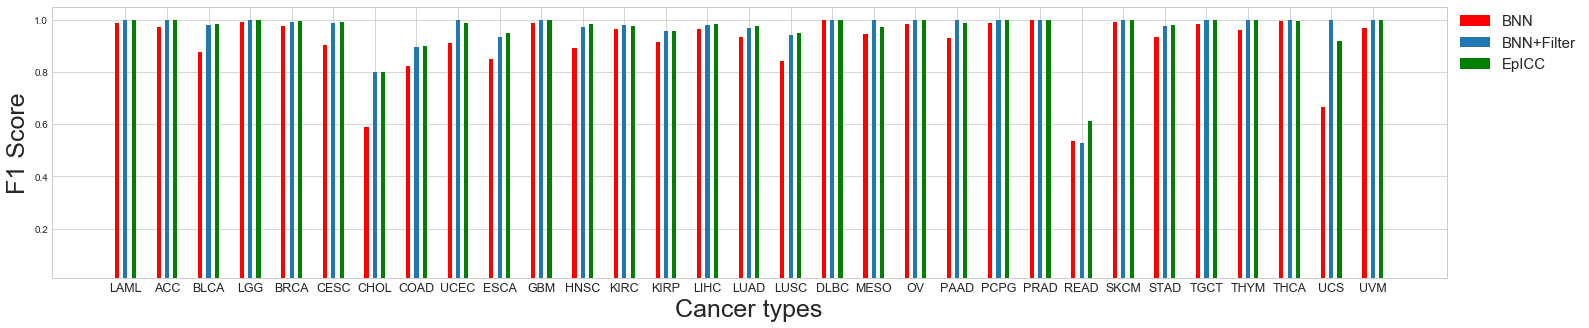

In [10]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(25,5))
fscore = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[2]
fscore_filter = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[2]
fscore_corrected = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test_new))[2]
plt.bar(np.arange(0,len(fscore))-0.2,fscore,label = 'BNN',color='r',width=0.1)
plt.bar(np.arange(0,len(fscore_filter)),fscore_filter,width=0.1,label = 'BNN+Filter')
plt.bar(np.arange(0,len(fscore_corrected))+0.2,np.array(fscore_corrected),label='EpICC',color='g',width=0.1)
plt.ylabel('F1 Score',fontsize=25)
plt.xlabel('Cancer types',fontsize=25)
plt.xticks(np.arange(0,len(fscore)),cancer_types,fontsize=12.5)
plt.ylim((0.01,1.05))
plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
ax = plt.axes()
ax.yaxis.grid(True,which='major')
plt.show()
